# Tutorial: Single chromosome optimization using OpenMiChroM


## This tutorial performs optimization in the MiChroM Parameters (Second-order optimization -> Hessian inversion)

*The first step is to import the OpenMiChroM modules.*

To install OpenMM and OpenMiChroM, follow the [instalation guide](https://open-michrom.readthedocs.io/en/latest/#).

The inputs and apps used in this tutorial can be downloaded [here](https://github.com/junioreif/OpenMiChroM/tree/main/Tutorials/MiChroM_Optimization).

<font color='red'>Types optimization is available in the OpenMichroM version 1.0.7.</font> 

In [1]:
# OpenMiChroM simulation module
from OpenMiChroM.ChromDynamics import MiChroM
# Optimization of MiChroM parameters module
from OpenMiChroM.Optimization import CustomMiChroMTraining
# Analysis tools module
from OpenMiChroM.CndbTools import cndbTools

# Extra modules to load and plot .dense file 
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.preprocessing import normalize
import numpy as np
import pandas as pd
import h5py
from scipy.optimize import curve_fit

*The second step is to have a look on the experimental Hi-C*

A Hi-C file is required for the analysis and training of the MiChroM Potentials (Types and Ideal Chromosome). The file format chosen here is a matrix .txt file (we call it the dense file).

For this tutorial, we will use chromosome 10 from GM12878 in 100 kb resolution. To extract it from the .hic file, we can use juicer_tools with the folowing command. Please note that the juicer_tools java file is located at the `apps` folder located at the `$HOME` directory.

In [2]:
%%bash
java -jar ~/apps/juicer_tools_1.22.01.jar dump observed Balanced -d https://hicfiles.s3.amazonaws.com/hiseq/gm12878/in-situ/combined.hic 10 10 BP 100000 input/chr10_100k.dense

WARN [2023-04-13T15:13:03,709]  [Globals.java:138] [main]  Development mode is enabled
INFO [2023-04-13T15:13:04,138]  [DirectoryManager.java:179] [main]  IGV Directory: /Users/ro21/igv
INFO [2023-04-13T15:13:04,317]  [HttpUtils.java:937] [main]  Range-byte request succeeded


This command downloads the .hic from the web and extracts the chromosome 10 in .dense format to the folder "input".

You can get more information about it at the [JuicerTools](https://github.com/aidenlab/juicer) documentation.

Visualize the .dense file.

number of beads:  1356


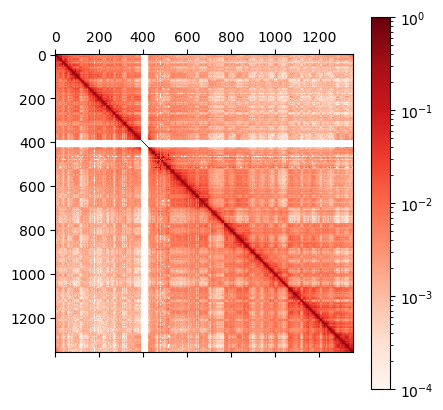

In [3]:
filename = 'input/chr10_100k.dense'
hic_file = np.loadtxt(filename)

r=np.triu(hic_file, k=1) 
r[np.isnan(r)]= 0.0
r = normalize(r, axis=1, norm='max') 
rd = np.transpose(r) 
r=r+rd + np.diag(np.ones(len(r)))
print("number of beads: ", len(r))
plt.matshow(r,norm=mpl.colors.LogNorm(vmin=0.0001, vmax=r.max()),cmap="Reds")  
plt.colorbar()

This Hi-C map has a resolution of 100 kb per bead, so the chromosome 10 model has a polymer chain with a total of 1356 beads.

The next step is to extract the sequence file containing the A/B compartments along the sequence by using the eigenvector decomposition. <br>

Using the juicertools, you can extract the eigenvector file. The eigenvector has values both negatives and positives and here we will arbitrary set positives as B and negatives as A. <br>

For more details about how it works, please take a look on this paper: https://pubs.acs.org/doi/full/10.1021/acs.jpcb.1c04174

In [4]:
%%bash
java -jar ~/apps/juicer_tools_1.22.01.jar eigenvector -p Balanced https://hicfiles.s3.amazonaws.com/hiseq/gm12878/in-situ/combined.hic 10 BP 100000 input/chr10_100k.eigen

WARN [2023-04-13T15:13:12,055]  [Globals.java:138] [main]  Development mode is enabled
INFO [2023-04-13T15:13:12,506]  [DirectoryManager.java:179] [main]  IGV Directory: /Users/ro21/igv
INFO [2023-04-13T15:13:12,700]  [HttpUtils.java:937] [main]  Range-byte request succeeded


And visualize the .eigen file.

Number of beads: A1 =  618 , B1 =  707


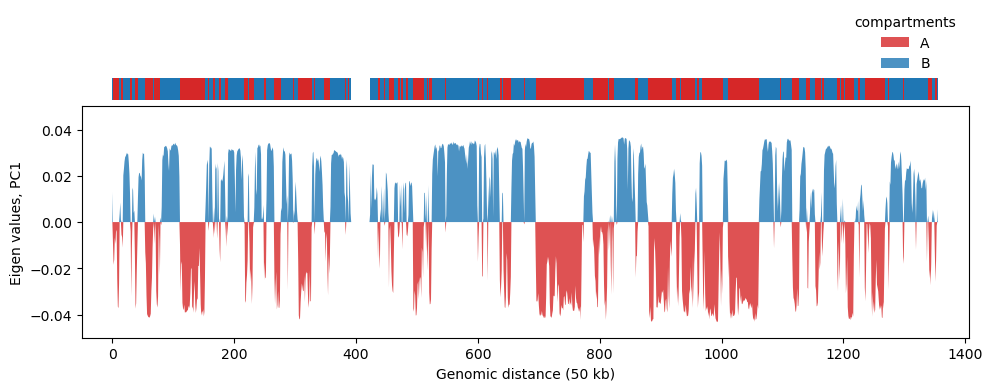

In [5]:
eigen = np.loadtxt("input/chr10_100k.eigen")

index = np.arange(eigen.size)
df = pd.Series(eigen, index=index)

A1_df = pd.Series(np.zeros(eigen.size), index=index) 
A1_df[df < 0] = df[df < 0]
B1_df = pd.Series(np.zeros(eigen.size), index=index) 
B1_df[df > 0] = df[df > 0]

NA_df = df.isna()
# y = sc.signal.savgol_filter(A1,20, 2)

fig, axes = plt.subplots(ncols=1, nrows=2,
                         figsize=(6.4*3/2, 4.8*2/3),
                         gridspec_kw={'height_ratios': [1, 10]})
fig.tight_layout()

fig.subplots_adjust(hspace=0.05) # top=0.92, bottom=0.01, wspace=0.)

# sequence
A11_df = A1_df.copy()
A11_df[A1_df<0] = 1
B11_df = B1_df.copy()
B11_df[B1_df>0] = 1

axes[0].axis('off')
width=1
axes[0].bar(A11_df.index, A11_df,
       width,
       color="tab:red")
axes[0].bar(B11_df.index, B11_df,
       width,
       color="tab:blue")

axes[0].set_xlim([-50,eigen.size + 50])

# Eigen PC1
step=1
axes[1].fill_between(A1_df.index[::step], A1_df[::step],  0,
                facecolor="tab:red",
                alpha=0.8,
                label="A")
axes[1].fill_between(B1_df.index[::step], B1_df[::step],  0,
                facecolor="tab:blue",
                alpha=0.8,
                label="B")

axes[1].set_ylim([-0.05,0.05])
axes[1].set_xlim([-50,eigen.size + 50])

axes[1].set_ylabel('Eigen values, PC1')
axes[1].set_xlabel('Genomic distance (50 kb)')

axes[1].legend(title='compartments', bbox_to_anchor=(1.,1.45), 
               frameon=False)

print("Number of beads: A1 = ", A1_df[A1_df<0].shape[0], 
      ", B1 = ", B1_df[B1_df>0].shape[0])

From the .eigen, file we can create the A/B sequence file.

In [6]:
%%bash
awk '{if ($1 < 0) print "A1"; else print "B1"}' input/chr10_100k.eigen | cat -n > input/seq_chr10_100k.txt
echo "Number of beads: "
awk '{print $2}' input/seq_chr10_100k.txt | sort | uniq -c

Number of beads: 
 618 A1
 738 B1


## 1\# Types Interaction Opmization

In addition to the homopolimer term, MiChroM energy function has two main terms: the type-to-type and Ideal Chromosome interactions. 

<!--![](https://pubs.acs.org/cms/10.1021/acs.jpcb.1c04174/asset/images/medium/jp1c04174_m010.gif)-->

${ U }_{\text{MiChroM} }(\vec { r } )={ U }_{ HP }\left( \vec { r }  \right) +\sum _{\tiny{ \begin{matrix}  k\ge l \\ k,l \in  \text{Types} \end{matrix} } }{ { \alpha }_{ kl } } \sum _{\tiny{ \begin{matrix} i \in \{ \text{Loci of Type k}\}  \\ j \in  \{ \text{Loci of Type l} \}  \end{matrix} }} f({ r }_{ ij }) +  \sum _{ d=3 }^{ { d }_{ cutoff } }{ \gamma (d)\sum _{ i }{ f({ r }_{ i,i+d }) }  }$

In this section, the types interaction terms will be minimized.

The pipeline to perform the Types Potential Optimization is the following:

1. Run a long simulation using the homopolymer + customTypes potential of the `OpenMiChroM` module. 
    The first iteration can start with all parameters equal to zero or set to an initial guess.

2. Get the frames from this simualtion to perform the inversion for Types.

3. In the end of the inversion, new values to types interactions will be produced.

4. Calcule the error/tolerance between the simulated and experimental parameters. If it is above the treshold, re-do steps 1-3 until reaching the treshold (usually 10% or 15% is enougth).

The Types file is a `.txt` with a matrix labeled with the values for each interaction. In this tutorial, we are training A and B types. <br> 

Lets create the initial file with this format:
<pre><code>
A,B
0,0
0,0
</pre></code>
For this matrix, we have AA AB BA BB interactions.

Save it as `lambda_0`

In [7]:
%%bash
echo "A1,B1
0,0
0,0" > input/lambda_0

cat input/lambda_0

A1,B1
0,0
0,0


With all the required inputs, lets perform a simulation for iteration 0.

In MiChroM initiation there are some variables to setup:

**time_step=0.01** (the time step using for integration, default is 0.01)<br>
**temperature=1** (Set the temperature of your simulation)<br>
**name='opt_chr10_100K'** (the simulation name)<br>

In [8]:
simulation = MiChroM(name='opt_chr10_100K', temperature=1.0, time_step=0.01)

    ***************************************************************************************     
     **** **** *** *** *** *** *** *** OpenMiChroM-1.0.6 *** *** *** *** *** *** **** ****      

         OpenMiChroM is a Python library for performing chromatin dynamics simulations.         
                            OpenMiChroM uses the OpenMM Python API,                             
                employing the MiChroM (Minimal Chromatin Model) energy function.                
      The chromatin dynamics simulations generate an ensemble of 3D chromosomal structures      
      that are consistent with experimental Hi-C maps, also allows simulations of a single      
                 or multiple chromosome chain using High-Performance Computing                  
                            in different platforms (GPUs and CPUs).                             
         OpenMiChroM documentation is available at https://open-michrom.readthedocs.io          

         OpenMiChroM is desc

Now you need to setup the platform that you will use, the options are:

**platform="OpenCL"** (it can also be CUDA or CPU depending of your system)<br>
**GPU="0" (optional)** (if you have more than one GPU device, you can set the GPUs that you want ["0", "1",...,"n"])<br>

In [9]:
simulation.setup(platform="OpenCL")

Set the folder name where the output will be saved.

In [10]:
simulation.saveFolder('iteration_0')

The next step is to setup your chromosome sequence and initial configuration.

In [11]:
mychro = simulation.createSpringSpiral(ChromSeq="input/seq_chr10_100k.txt")

Load the initial structure in the `simulation` object.

In [12]:
simulation.loadStructure(mychro, center=True)

Now it is time to include the force field in the `simulation` object

Lets separate forces in two sets:

**Homopolymer Potentials**  

In [13]:
simulation.addFENEBonds(kfb=30.0)
simulation.addAngles(ka=2.0)
simulation.addRepulsiveSoftCore(Ecut=4.0)

**Chromosome Potentials**

In this tutorial, it is used the CustomTypes potential. <br>
Here we need to pass a file that contains a matrix of interactions for each other different type of chromosome.
To check that, you can look on the [OpenMiChroM](https://open-michrom.readthedocs.io/en/latest/OpenMiChroM.html#OpenMiChroM.ChromDynamics.MiChroM.addCustomTypes) documentation. <br>

In [14]:
simulation.addCustomTypes(mu=3.22, rc = 1.78, TypesTable='input/lambda_0')

Note: these valeus for $\mu$ and $r_c$ were calculated for human GM12878 cells and can be changed for other species.

The last potential to be added is the spherical restraint in order to collapse the initial structure.

In [15]:
simulation.addFlatBottomHarmonic(kr=5*10**-3, n_rad=8.0)

Now we will run a short simulation in order to get a collapsed structure.

There are two variables that control the chromosomes simulation steps:

**block:** The number of steps performed in each cycle.<br>
**n_blocks:** The number of blocks that will be perfomed. <br>

In this example, to perfom the collapsing we will run $1\times10^3 \times  10^2 = 1\times10^5$ steps

In [16]:
block    = 1000
n_blocks = 100

We can save the radius of gyration of each block to observe the convergence into the collapsed state (the time required here depends on the size of your chromosome).

In [17]:
rg = []

In [18]:
for _ in range(n_blocks):
    simulation.runSimBlock(block, increment=False)
    rg.append(simulation.chromRG())

#save a collapsed structure in pdb format for inspection
simulation.saveStructure(mode = 'pdb')

Number of exceptions: 1355
adding force  FENEBond 0
adding force  AngleForce 1
Add exclusions for RepulsiveSoftCore force
adding force  RepulsiveSoftCore 2
Add exclusions for CustomTypes force
adding force  CustomTypes 3
adding force  FlatBottomHarmonic 4
Positions... 
 loaded!
potential energy is 31.227323
bl=0 pos[1]=[101.4 -2.1 2.0] dr=2.84 t=10.0ps kin=1.68 pot=31.18 Rg=71.741 SPS=1209 
bl=0 pos[1]=[98.5 -0.0 3.6] dr=3.78 t=20.0ps kin=1.95 pot=30.47 Rg=68.734 SPS=1252 
bl=0 pos[1]=[94.8 -1.2 3.8] dr=3.74 t=30.0ps kin=1.88 pot=29.64 Rg=65.548 SPS=1698 
bl=0 pos[1]=[90.0 -2.1 4.4] dr=3.45 t=40.0ps kin=1.84 pot=28.88 Rg=62.658 SPS=1675 
bl=0 pos[1]=[86.7 -1.7 3.7] dr=3.44 t=50.0ps kin=1.83 pot=28.18 Rg=59.790 SPS=1682 
bl=0 pos[1]=[83.5 -2.2 6.8] dr=3.25 t=60.0ps kin=1.79 pot=27.55 Rg=57.157 SPS=1473 
bl=0 pos[1]=[77.4 -0.0 4.4] dr=3.13 t=70.0ps kin=1.75 pot=26.99 Rg=54.657 SPS=1685 
bl=0 pos[1]=[75.3 0.4 4.1] dr=3.09 t=80.0ps kin=1.78 pot=26.45 Rg=52.247 SPS=1684 
bl=0 pos[1]=[72.7 1

Some details about the output for each block performed:

**bl=0** is the number of each block, in this case we set increment=False, so the number of steps is not accounted.<br>
**pos\[1\]=\[X,Y,Z\]** the spatial position for the first bead. <br>
**dr=1.85** show the average positions displacement in each block (in units os sigma). <br>
**t=1000.0 ps** the time step. in this case we set increment=False, so the number of steps is not accounted.<br>
**kin=1.48** is the kinect energy of the system.<br>
**pot=21.60** is the potential energy of the system. <br>
**RG=11.809** is the radius of gyration in the end of each block. <br>
**SPS=1538** is the steps per second of each block. A way to look how fast the computations are being performed. In this case, it was executed in a MB Pro 2021 with a Apple M1 Max.

Check the convergence of the radius of gyration:

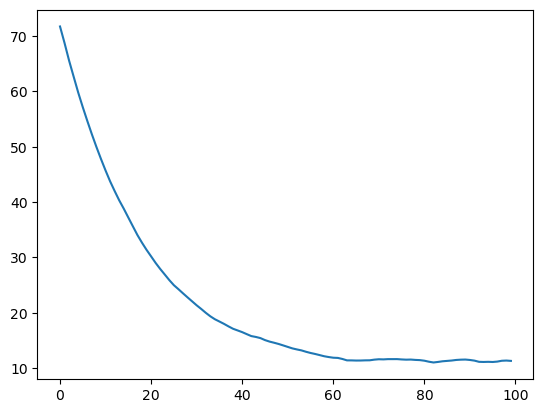

In [19]:
plt.plot(rg)

The next step is to remove the restraint force in order to run the sampling simulation. It also adds a confinement potential with density = 0.1 (volume fraction).

In [20]:
# Remove Flat initialized in Collapse
simulation.removeFlatBottomHarmonic()

# Add a confinement potential with density=0.1 (volume fraction)
simulation.addSphericalConfinementLJ()

14.793027236438204

Initiate the `optimization` object for this tutorial section.

In [21]:
optimization = CustomMiChroMTraining(ChromSeq="input/seq_chr10_100k.txt", 
                                     TypesTable='input/lambda_0',
                                     mu=3.22, rc = 1.78)

The next step is to perform a long simulation to feed the optimization parameters. <br>

In order to get a good inversion calcultation, it is important to have around $1\times10^5$ frames from a certain amount of different replicas. For example, $20$ replicas with $5.000$ saved frames from each. <br> 

This can take some time, so in this tutorial we will use just 1 replica of $5.000$ frames saved every $1.000$ steps. <br>

    block = 1000
    n_blocks = 5000

In [22]:
block    = 1000
n_blocks = 5000

for _ in range(n_blocks):
    # perform 1 block of simulation
    simulation.runSimBlock(block, increment=True) 
    
    # feed the optimization with the last chromosome configuration
    optimization.prob_calculation_types(simulation.getPositions())

bl=1 pos[1]=[12.5 0.4 6.0] dr=1.95 t=1010.0ps kin=1.51 pot=21.49 Rg=11.331 SPS=992 
bl=2 pos[1]=[12.2 0.4 8.8] dr=1.98 t=1020.0ps kin=1.47 pot=21.55 Rg=11.478 SPS=1414 
bl=3 pos[1]=[9.1 0.2 9.3] dr=1.88 t=1030.0ps kin=1.47 pot=21.52 Rg=11.556 SPS=1254 
bl=4 pos[1]=[8.1 -0.1 7.6] dr=1.83 t=1040.0ps kin=1.47 pot=21.55 Rg=11.719 SPS=1209 
bl=5 pos[1]=[8.0 -2.6 3.2] dr=1.93 t=1050.0ps kin=1.49 pot=21.50 Rg=11.931 SPS=1343 
bl=6 pos[1]=[6.6 -2.8 5.4] dr=1.95 t=1060.0ps kin=1.50 pot=21.53 Rg=12.170 SPS=1446 
bl=7 pos[1]=[6.5 -1.8 6.2] dr=1.94 t=1070.0ps kin=1.54 pot=21.49 Rg=12.399 SPS=1495 
bl=8 pos[1]=[8.1 -0.5 4.9] dr=1.92 t=1080.0ps kin=1.53 pot=21.52 Rg=12.596 SPS=1585 
bl=9 pos[1]=[7.9 -1.0 6.4] dr=1.92 t=1090.0ps kin=1.51 pot=21.55 Rg=12.722 SPS=1554 
bl=10 pos[1]=[9.6 -1.1 6.4] dr=1.90 t=1100.0ps kin=1.56 pot=21.52 Rg=12.830 SPS=1573 
bl=11 pos[1]=[9.5 -1.6 7.4] dr=1.91 t=1110.0ps kin=1.53 pot=21.43 Rg=12.955 SPS=981 
bl=12 pos[1]=[9.5 -3.5 4.7] dr=1.92 t=1120.0ps kin=1.43 pot=21.49 

In the end of each replica simulation, we need to save some important values required to calculate the inversion. <br>

We are saving these files using the H5 compression because it is faster to write/read. <br>

**Note**: attention to this step. We have these 4 files for each replica for each iteration step. Be organized!

In [23]:
replica="1"

with h5py.File(simulation.folder + "/Nframes_" + replica + ".h5", 'w') as hf:
    hf.create_dataset("Nframes",  data=optimization.Nframes)

with h5py.File(simulation.folder + "/Pold_" + replica + ".h5", 'w') as hf:
    hf.create_dataset("Pold",  data=optimization.Pold)

# Specific for Types minimization
with h5py.File(simulation.folder + "/Pold_type_" + replica + ".h5", 'w') as hf:
    hf.create_dataset("Pold_type",  data=optimization.Pold_type)

with h5py.File(simulation.folder + "/PiPj_type_" + replica + ".h5", 'w') as hf:
    hf.create_dataset("PiPj_type",  data=optimization.PiPj_type)

The first part of the optimization is finished. Look inside the output folder to see these 4 files that will be used in next step.

In [24]:
%%bash
ls iteration_0/*.h5

iteration_0/Nframes_1.h5
iteration_0/PiPj_type_1.h5
iteration_0/Pold_1.h5
iteration_0/Pold_type_1.h5


The next part is the inversion. It is quite simple, just feed the optmization object with all replicas and make the inversion to get the new lambda file.

In [25]:
inversion = CustomMiChroMTraining(ChromSeq="input/seq_chr10_100k.txt", 
                                  TypesTable='input/lambda_0',
                                  mu=3.22, rc = 1.78)

In [26]:
iterations = "iteration_0"
replica    = "1"

with h5py.File(iterations + "/Nframes_" + replica + ".h5", 'r') as hf:
    inversion.Nframes += hf['Nframes'][()]

with h5py.File(iterations + "/Pold_" + replica + ".h5", 'r') as hf:
    inversion.Pold += hf['Pold'][:]

# For Types
with h5py.File(iterations + "/Pold_type_" + replica + ".h5", 'r') as hf:
    inversion.Pold_type += hf['Pold_type'][:]

with h5py.File(iterations + "/PiPj_type_" + replica + ".h5", 'r') as hf:
    inversion.PiPj_type += hf['PiPj_type'][:]

With the parameters of all replicas, we calculate the inversion and get the new lambdas. It is calculated by using the Newton Method: <br>

$\lambda_1 = \lambda_0 - \delta\times\lambda_{actual}$

$\delta$ is the learning rate or damp, it can be adjusted in order to get values between [-1:0]. The average value of MiChroM's parameters for Human GM12878 is -0.3 when generating $1\times10^5$ configurations among different replicas.

In [27]:
lambdas = inversion.get_lambdas_types(exp_map="input/chr10_100k.dense", 
                                      damp=3e-7)

print(lambdas)  

         A1        B1
0 -0.129980 -0.339399
1 -0.339399 -0.282689


Save the new lambda (`lambda_1`) and other files to analyze the inversion.

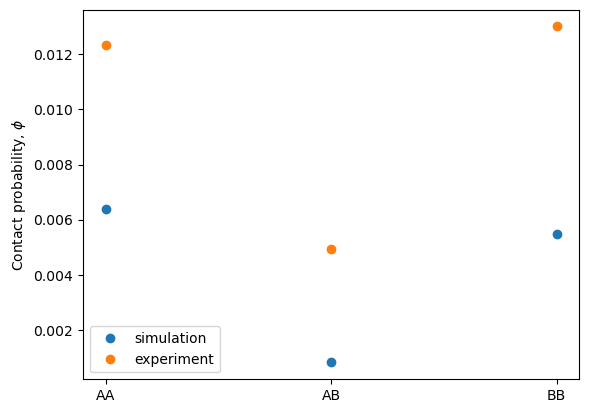

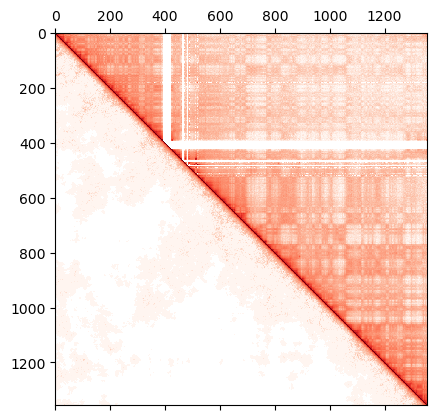

In [28]:
iteration = "0"

# Probabilities of As/Bs in the simulation and experiment
phi_sim = inversion.calc_phi_sim_types().ravel()
phi_exp = inversion.calc_phi_exp_types().ravel()

np.savetxt('iteration_0/phi_sim_' + iteration, phi_sim)
np.savetxt('iteration_0/phi_exp', phi_exp)

plt.plot(phi_sim[phi_sim>0], 'o', label="simulation")
plt.plot(phi_exp[phi_exp>0], 'o', label="experiment")
plt.ylabel(r'Contact probability, $\phi$')
labels_exp = ["AA", "AB", "BB"]
plt.xticks(np.arange(len(labels_exp)), labels_exp)
plt.legend()

# Save and plot the simulated Hi-C
dense_sim = inversion.get_HiC_sim()
np.savetxt('iteration_0/hic_sim_' + iteration + '.dense', dense_sim)

dense_exp = np.loadtxt(filename)
dense_exp[np.isnan(dense_exp)] = 0.0
dense_exp = normalize(dense_exp, axis=1, norm='max')
r = np.zeros(dense_sim.size).reshape(dense_sim.shape)
r = np.triu(dense_exp, k=1) + np.tril(dense_sim, k=-1) + np.diag(np.ones(len(r)))

plt.matshow(r, 
            norm=mpl.colors.LogNorm(vmin=0.0001, 
                                    vmax=dense_sim.max()), 
            cmap="Reds")

# Save the new lambda file
lambdas.to_csv("iteration_0/lambda_1", index=False)

Redo these steps using the new lambda file (`lambda_1`) as input for Types potential in the next iteration. 

The tolerance can be calculate using `phi_sim_1` and `phi_exp` by the equation:<br>

$tolerance = \frac{|\phi_{sim}-\phi_{exp}|}{\phi_{exp}}$

This is appended in to file  `tolerance_and_pearson_types`.

In [29]:
%%bash
cat tolerance_and_pearson_types

Tolerance: 0.621787  Pearson's Correlation: 0.854001


We included a folder named `scripts` that has some `.py` and `.slurm` files that can be used to run this optimization in parallel using slurm clusters. It is located in our github repository https://github.com/junioreif/OpenMiChroM.

## 2\# Ideal Chromosome Interaction Opmization

Following the previous section protocoal, now it is time to learn how to minimize the Ideal Chromosome (IC) interaction, the last term of our hamiltonian

<!--![](https://pubs.acs.org/cms/10.1021/acs.jpcb.1c04174/asset/images/medium/jp1c04174_m010.gif)-->

${ U }_{\text{MiChroM} }(\vec { r } )={ U }_{ HP }\left( \vec { r }  \right) +\sum _{\tiny{ \begin{matrix}  k\ge l \\ k,l \in  \text{Types} \end{matrix} } }{ { \alpha }_{ kl } } \sum _{\tiny{ \begin{matrix} i \in \{ \text{Loci of Type k}\}  \\ j \in  \{ \text{Loci of Type l} \}  \end{matrix} }} f({ r }_{ ij }) +  \sum _{ d=3 }^{ { d }_{ cutoff } }{ \gamma (d)\sum _{ i }{ f({ r }_{ i,i+d }) }  }$

The pipeline to perform the IC minimization is similar to the previous one:

1. Run a long simulation using the homopolymer + types potential + addCustomIC of the `OpenMiChroM` module. 
    The first iteration can start with all parameters equal to zero or set to an initial guess.

2. Get the frames from this simualtion to perform the inversion.

3. In the end of the inversion, new values to the interactions will be produced.

4. Calcule the tolerance between the simulated and experimental parameters. If it is above the treshold, re-do steps 1-3 until reaching the treshold (usually 10% or 15% is enougth).

The IC file is a single column `.txt` with the values for each interaction. The file lenght should the genome distance (`d`) that you want to train. In the above equation, it goes from `d = 3` to a certain cutoff that normaly would be 200 for the human chromosome. <br> 

Lets create the initial file with this format:
<pre><code>
0
0
.
.
.
0
</pre></code>

Save it as `lambda_0`.

In [30]:
%%bash
rm input/lambda_0_IC &> /dev/null
for (( i=3; i<=1356; i++ )); do echo 0 >> input/lambda_IC_0; done
wc -l input/lambda_IC_0

    2708 input/lambda_IC_0


Again, create the simulation that will colapse the initial structure.

In [31]:
simulation_ic = MiChroM(name='opt_ic_chr10_100K', temperature=1.0, time_step=0.01)

simulation_ic.setup(platform="OpenCL")
simulation_ic.saveFolder('iteration_ic_0')
mychro_ic = simulation_ic.createSpringSpiral(ChromSeq="input/seq_chr10_100k.txt")
simulation_ic.loadStructure(mychro_ic, center=True)

# Adding Potentials section

# **Homopolymer Potentials**  
simulation_ic.addFENEBonds(kfb=30.0)
simulation_ic.addAngles(ka=2.0)
simulation_ic.addRepulsiveSoftCore(Ecut=4.0)

# **Chromosome Potentials**
simulation_ic.addTypetoType()
simulation_ic.addCustomIC(IClist="input/lambda_IC_0",
                          dinit=3, dend=200) 

# The restriction term for colapsing the beads
simulation_ic.addFlatBottomHarmonic(kr=5*10**-3, n_rad=8.0)

    ***************************************************************************************     
     **** **** *** *** *** *** *** *** OpenMiChroM-1.0.6 *** *** *** *** *** *** **** ****      

         OpenMiChroM is a Python library for performing chromatin dynamics simulations.         
                            OpenMiChroM uses the OpenMM Python API,                             
                employing the MiChroM (Minimal Chromatin Model) energy function.                
      The chromatin dynamics simulations generate an ensemble of 3D chromosomal structures      
      that are consistent with experimental Hi-C maps, also allows simulations of a single      
                 or multiple chromosome chain using High-Performance Computing                  
                            in different platforms (GPUs and CPUs).                             
         OpenMiChroM documentation is available at https://open-michrom.readthedocs.io          

         OpenMiChroM is desc

Execute the simulation to colapse the initial structure

Number of exceptions: 1355
adding force  FENEBond 0
adding force  AngleForce 1
Add exclusions for RepulsiveSoftCore force
adding force  RepulsiveSoftCore 2
Add exclusions for TypetoType force
adding force  TypetoType 3
Add exclusions for CustomIC force
adding force  CustomIC 4
adding force  FlatBottomHarmonic 5
Positions... 
 loaded!
potential energy is 31.148000
bl=0 pos[1]=[103.9 -5.2 3.1] dr=2.98 t=10.0ps kin=1.69 pot=31.11 Rg=71.759 SPS=1477 
bl=0 pos[1]=[100.0 -3.5 6.2] dr=3.82 t=20.0ps kin=1.86 pot=30.41 Rg=68.810 SPS=1516 
bl=0 pos[1]=[96.5 -1.9 5.8] dr=3.73 t=30.0ps kin=1.95 pot=29.57 Rg=65.671 SPS=1377 
bl=0 pos[1]=[92.0 -2.3 4.9] dr=3.61 t=40.0ps kin=1.95 pot=28.79 Rg=62.628 SPS=1607 
bl=0 pos[1]=[86.2 -1.4 3.0] dr=3.57 t=50.0ps kin=1.88 pot=27.96 Rg=59.608 SPS=1598 
bl=0 pos[1]=[84.7 0.2 2.9] dr=3.50 t=60.0ps kin=1.91 pot=27.25 Rg=56.653 SPS=1627 
bl=0 pos[1]=[80.1 1.5 4.1] dr=3.35 t=70.0ps kin=1.96 pot=26.66 Rg=53.905 SPS=1626 
bl=0 pos[1]=[74.6 1.8 3.4] dr=3.13 t=80.0ps ki

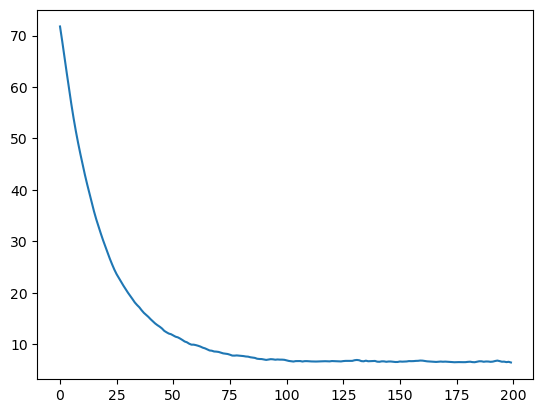

In [32]:
block    = 1000
n_blocks = 200

rg_ic = []

for _ in range(n_blocks):
    simulation_ic.runSimBlock(block, increment=False)
    rg_ic.append(simulation_ic.chromRG())

#save a collapsed structure in pdb format for inspection
simulation_ic.saveStructure(mode = 'pdb')

plt.plot(rg_ic)

It is time to remove the flat bottom constraint and include the spherical confinement mimicking the nuclear density. 

In [33]:
# Remove Flat initialized in Collapse
simulation_ic.removeFlatBottomHarmonic()

# Add a confinement potential with density=0.1 (volume fraction)
simulation_ic.addSphericalConfinementLJ()

14.793027236438204

And create the IC optimization object.

In [34]:
optimization_ic = CustomMiChroMTraining(ChromSeq="input/seq_chr10_100k.txt", 
                                        TypesTable='input/lambda_0',
                                        IClist="input/lambda_IC_0",
                                        dinit=3, dend=200)

The next step is to perform a long simulation to feed the optimization parameters. <br>

In order to get a good inversion calcultation, it is important to have around $1\times10^5$ frames from a certain amount of different replicas. For example, $20$ replicas with $5.000$ saved frames from each. <br> 

This can take some time, so in this tutorial we will use just 1 replica. <br>

In [35]:
block    = 1000
n_blocks = 5000

for _ in range(n_blocks):
    # perform 1 block of simulation
    simulation_ic.runSimBlock(block, increment=True)
    
    # feed the optimization with the last chromosome configuration
    optimization_ic.prob_calculation_IC(simulation_ic.getPositions())


bl=1 pos[1]=[7.9 3.7 -5.5] dr=1.33 t=2010.0ps kin=1.49 pot=20.23 Rg=6.574 SPS=1206 
bl=2 pos[1]=[8.8 2.8 -7.3] dr=1.36 t=2020.0ps kin=1.46 pot=20.26 Rg=6.637 SPS=1063 
bl=3 pos[1]=[8.4 3.6 -6.0] dr=1.31 t=2030.0ps kin=1.48 pot=20.26 Rg=6.640 SPS=1382 
bl=4 pos[1]=[9.2 4.1 -3.8] dr=1.35 t=2040.0ps kin=1.49 pot=20.30 Rg=6.629 SPS=1388 
bl=5 pos[1]=[10.1 1.4 -3.4] dr=1.39 t=2050.0ps kin=1.51 pot=20.29 Rg=6.604 SPS=1381 
bl=6 pos[1]=[9.2 1.0 -7.0] dr=1.38 t=2060.0ps kin=1.56 pot=20.27 Rg=6.499 SPS=1393 
bl=7 pos[1]=[8.2 0.2 -5.9] dr=1.36 t=2070.0ps kin=1.51 pot=20.34 Rg=6.545 SPS=1418 
bl=8 pos[1]=[8.6 -1.4 -5.2] dr=1.42 t=2080.0ps kin=1.53 pot=20.28 Rg=6.550 SPS=1396 
bl=9 pos[1]=[10.7 -0.3 -2.4] dr=1.37 t=2090.0ps kin=1.50 pot=20.35 Rg=6.544 SPS=1391 
bl=10 pos[1]=[9.0 -2.0 -2.4] dr=1.43 t=2100.0ps kin=1.52 pot=20.32 Rg=6.582 SPS=1133 
bl=11 pos[1]=[7.3 -2.9 -3.2] dr=1.32 t=2110.0ps kin=1.51 pot=20.25 Rg=6.528 SPS=1402 
bl=12 pos[1]=[9.6 -4.8 -3.5] dr=1.34 t=2120.0ps kin=1.45 pot=20.26 R

It is time to save the important files required for the inversion. <br>

These files are prefered to be saved using the H5 compression. <br>

**Note**: attention to this step. We have these 4 files for each replica for each iteration step. Be organized!

In [36]:
replica="1"

with h5py.File(simulation_ic.folder + "/Nframes_" + replica + ".h5", 'w') as hf:
    hf.create_dataset("Nframes",  data=optimization_ic.Nframes)

with h5py.File(simulation_ic.folder + "/Pold_" + replica + ".h5", 'w') as hf:
    hf.create_dataset("Pold",  data=optimization_ic.Pold)

# Specific for IC minimization
with h5py.File(simulation_ic.folder + "/PiPj_IC_" + replica + ".h5", 'w') as hf:
    hf.create_dataset("PiPj_IC",  data=optimization_ic.PiPj_IC)

In [37]:
%%bash
ls iteration_ic_0/*.h5

iteration_ic_0/Nframes_1.h5
iteration_ic_0/PiPj_IC_1.h5
iteration_ic_0/Pold_1.h5


The next part is the inversion. We need to feed the optmization object with all replicas and make the inversion to get the new lambda file.

In [38]:
inversion_ic = CustomMiChroMTraining(ChromSeq="input/seq_chr10_100k.txt",
                                     TypesTable='input/lambda_0',
                                     IClist="input/lambda_IC_0",    
                                     dinit=3, dend=200)

In [39]:
iterations = "iteration_ic_0"
replica    = "1"

with h5py.File(iterations + "/Nframes_" + replica + ".h5", 'r') as hf:
    inversion_ic.Nframes += hf['Nframes'][()]

with h5py.File(iterations + "/Pold_" + replica + ".h5", 'r') as hf:
    inversion_ic.Pold += hf['Pold'][:]

# For IC
with h5py.File(iterations + "/PiPj_IC_" + replica + ".h5", 'r') as hf:
    inversion_ic.PiPj_IC += hf['PiPj_IC'][:]

With the parameters of all replicas, we calculate the inversion and get the new lambdas. It is calculated by using the Newton Method: <br>

$\lambda_1 = \lambda_0 - \delta\times\lambda_{actual}$

$\delta$ is the learning rate or damp, it can be adjusted in order to get values between [-1:0]. The average value of MiChroM's parameters for Human GM12878 is -0.3 when generating $1\times10^5$ configurations among different replicas.

In [40]:
lambdas_ic = inversion_ic.get_lambdas_IC(exp_map="input/chr10_100k.dense",
                                         damp=5e-4)

lambdas_ic.size, lambdas_ic[:5]

(197, array([-0.06625294, -1.63630439,  0.2064909 ,  0.12058404, -0.03533482]))

Save the new lambda (`lambda_1_ic`) and other files to analyze the inversion.

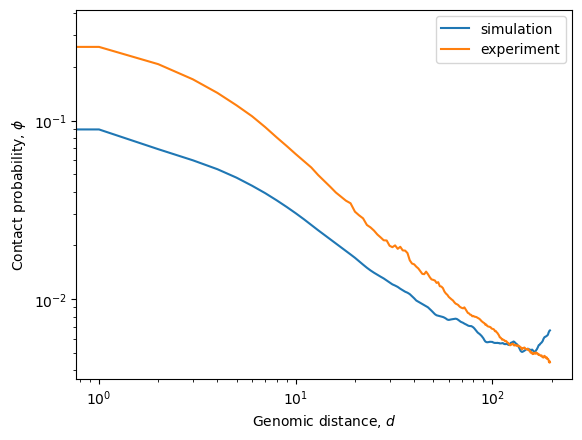

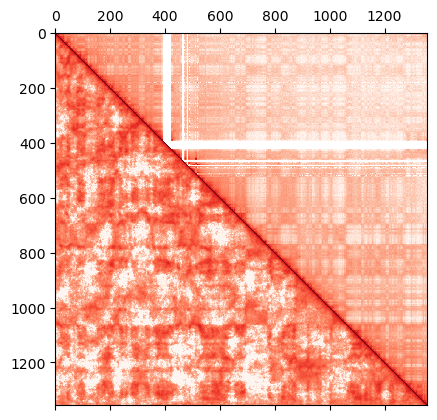

In [41]:
iteration = "0"

# Probabilities of As/Bs in the simulation and experiment
phi_sim = inversion_ic.calc_phi_sim_IC()
phi_exp = inversion_ic.calc_phi_exp_IC()

np.savetxt('iteration_ic_0/phi_sim_' + iteration, phi_sim)
np.savetxt('iteration_ic_0/phi_exp', phi_exp)

plt.plot(phi_sim, label="simulation")
plt.plot(phi_exp, label="experiment")
plt.ylabel(r'Contact probability, $\phi$')
plt.xlabel(r'Genomic distance, $d$')
plt.yscale('log')
plt.xscale('log')
plt.legend()

# Save and plot the simulated Hi-C
dense_sim = inversion_ic.get_HiC_sim()
np.savetxt('iteration_ic_0/hic_sim_' + iteration + '.dense', dense_sim)

dense_exp = np.loadtxt(filename)
dense_exp[np.isnan(dense_exp)] = 0.0
dense_exp = normalize(dense_exp, axis=1, norm='max')
r = np.zeros(dense_sim.size).reshape(dense_sim.shape)
r = np.triu(dense_exp, k=1) + np.tril(dense_sim, k=-1) + np.diag(np.ones(len(r)))

plt.matshow(r, 
            norm=mpl.colors.LogNorm(vmin=0.0001, 
                                    vmax=dense_sim.max()), 
            cmap="Reds")

# Save the new lambda file
np.savetxt("iteration_ic_0/lambda_1", lambdas_ic)

The simulated interaction terms (`lambdas_1` data) can be used to fit a model in order to run production simulations with longer cutoffs in the IC energy term. The resulting model is used in the `addCustomIC` method of the `OpenMiChroM` class.

[-0.14260129  3.58641988  0.82703462] [0.15690074 5.51415182 1.68569841]


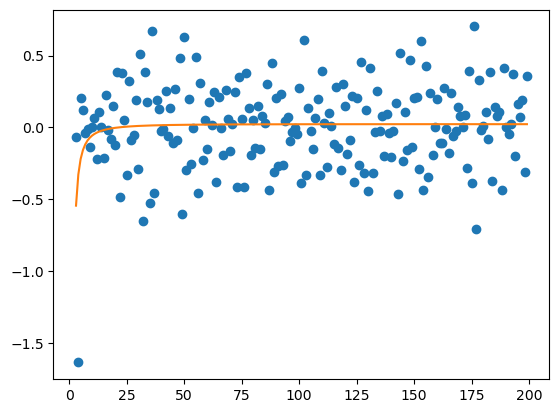

In [43]:
def objective1(x, a, b, c):
	return -a / np.log(x) - b / x**2 - c / x

y = lambdas_ic
x = np.arange(3, lambdas_ic.size + 3)
plt.scatter(x, y, label='simulation')

# curve fit
popt, pcov = curve_fit(objective1, x, y)
a, b, c = popt
standard_dev = np.sqrt(np.diag(pcov))

# IC generated model 
print(popt, standard_dev)

# plot the fit
x_fit = x
y_fit = objective1(x_fit, a, b, c)

plt.plot(x_fit, y_fit, label='fitting', 
	 	 color='#ff7f0e')

Nice job! You have completed the optimization tutorial of the MiChroM energy terms. 